# new model training for cite Guage

In [1]:
# Memory-Efficient DBLP Citation Network Training Pipeline
# Optimized for laptop/limited memory environments

# ============================================================================
# BLOCK 1: Setup and Configuration
# ============================================================================

import os
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import warnings
from typing import List, Union, Optional, Dict, Any
import joblib
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Memory monitoring function
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

# Enhanced logging configuration
def setup_logging(step_name: str, log_level: int = logging.INFO) -> logging.Logger:
    """Setup logging with memory monitoring"""
    log_filename = f"{step_name}.log"
    
    # Clear existing handlers to prevent duplicates
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s - [MEM: {:.1f}MB] - %(message)s'.format(get_memory_usage())
    )
    
    # Setup handlers
    file_handler = logging.FileHandler(log_filename, mode='w')
    file_handler.setFormatter(formatter)
    
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    
    # Configure root logger
    logging.basicConfig(
        level=log_level,
        handlers=[file_handler, console_handler],
        format='%(asctime)s - %(levelname)s - [MEM: {:.1f}MB] - %(message)s'.format(get_memory_usage())
    )
    
    logger = logging.getLogger(step_name)
    return logger

# Memory management utilities
def force_garbage_collection():
    """Force garbage collection and log memory usage"""
    before_mem = get_memory_usage()
    gc.collect()
    after_mem = get_memory_usage()
    print(f"Memory: {before_mem:.1f}MB -> {after_mem:.1f}MB (freed: {before_mem-after_mem:.1f}MB)")

def check_memory_limit(limit_mb: int = 8192):
    """Check if memory usage exceeds limit"""
    current_mem = get_memory_usage()
    if current_mem > limit_mb:
        print(f"WARNING: Memory usage ({current_mem:.1f}MB) exceeds limit ({limit_mb}MB)")
        force_garbage_collection()
        return True
    return False

# Configuration
CONFIG = {
    'DATA_DIR': Path('.'),
    'KAGGLE_CSV_FILE': 'dblp-citation-network-v14.csv',
    
    # --- Intermediate file paths ---
    'CLEANED_PARQUET_FILE': 'dblp_cleaned.parquet',
    'TFIDF_COMBINED_FEATURES_PATH': Path('.') / 'tfidf_combined_sparse_features.npz',
    
    # --- OUTPUT PATHS (Point to current directory as it's inside ml_models) ---
    'ML_MODELS_DIR': Path('.'),
    'MODEL_PATH': Path('.') / 'ridge_model.pkl',
    'VECTORIZERS_PATH': Path('.') / 'tfidf_vectorizers.pkl',
    'LDA_MODEL_PATH': Path('.') / 'lda_model.pkl',
    'LDA_VECTORIZER_PATH': Path('.') / 'lda_count_vectorizer.pkl',
    'MODEL_RESULTS_PATH': Path('.') / 'model_results.pkl',
    
    # Memory optimization settings
    'CHUNK_SIZE': 10000,  # Process data in chunks
    'MAX_MEMORY_MB': 6144,  # 6GB memory limit
    'DTYPE_OPTIMIZATIONS': {
        'year': 'int16',
        'n_citation': 'int32',
        'has_doi': 'int8',
        'has_url': 'int8',
        'title_length': 'int16',
        'abstract_length': 'int32',
        'num_keywords': 'int16',
        'age': 'int16',
        'num_references': 'int16'
    },
    
    # TF-IDF parameters (reduced for memory efficiency)
    'TFIDF_MAX_FEATURES': 5000,  # Reduced from 10000
    'TFIDF_MIN_DF_TITLE_ABSTRACT': 10,  # Increased to reduce features
    'TFIDF_MIN_DF_KEYWORDS': 2,
    'TFIDF_NGRAM_RANGE': (1, 2),
    
    # LDA (Topic Modeling) parameters
    'LDA_N_TOPICS': 10,        # Number of topics to discover
    'LDA_MAX_FEATURES': 5000,  # Max words for the LDA vocabulary
    'LDA_MAX_DF': 0.9,         # Ignore words appearing in > 90% of abstracts
    'LDA_MIN_DF': 20,          # Ignore words appearing in < 20 abstracts
    
    # Processing settings
    'RANDOM_STATE': 42,
    'N_JOBS': -1  # Use all available cores
}

# Numerical features list
NUMERICAL_FEATURES_COLS = [
    'title_length', 'abstract_length', 'num_keywords',
    'age', 'num_references', 'has_doi', 'has_url'
]

# Create data directory
CONFIG['ML_MODELS_DIR'].mkdir(exist_ok=True)

print("=" * 60)
print("MEMORY-EFFICIENT DBLP CITATION NETWORK TRAINING PIPELINE")
print("=" * 60)
print(f"Initial memory usage: {get_memory_usage():.1f}MB")
print(f"Configuration loaded. Data directory: {CONFIG['DATA_DIR']}")
print(f"Memory limit set to: {CONFIG['MAX_MEMORY_MB']}MB")

MEMORY-EFFICIENT DBLP CITATION NETWORK TRAINING PIPELINE
Initial memory usage: 210.8MB
Configuration loaded. Data directory: .
Memory limit set to: 6144MB


In [2]:


# ============================================================================
# BLOCK 2: Data Loading with Memory Optimization
# ============================================================================

def load_data_efficiently(file_path: Path, chunk_size: int = 10000) -> pd.DataFrame:
    """Load CSV data efficiently using chunking and memory optimization"""
    import csv
    
    logger = setup_logging("data_loading")
    logger.info("Starting efficient data loading")
    
    full_csv_path = CONFIG['DATA_DIR'] / CONFIG['KAGGLE_CSV_FILE']
    
    if not full_csv_path.exists():
        error_msg = f"Dataset CSV file not found at '{full_csv_path}'"
        logger.error(error_msg)
        raise FileNotFoundError(error_msg)
    
    logger.info(f"Loading data from: {full_csv_path}")
    
    # First, get file size for progress tracking
    file_size = full_csv_path.stat().st_size / 1024 / 1024  # MB
    logger.info(f"File size: {file_size:.1f}MB")
    
    try:
        # Increase CSV field size limit to handle large fields
        csv.field_size_limit(min(2**31-1, 10**7))  # Set to 10MB or system max
        logger.info("CSV field size limit increased for large fields")
        
        # Read in chunks to manage memory
        chunks = []
        total_rows = 0
        
        chunk_reader = pd.read_csv(
            full_csv_path,
            sep='|',
            engine='python',
            on_bad_lines='skip',
            chunksize=chunk_size,
            low_memory=True,
            quoting=csv.QUOTE_NONE,  # Handle quotes more flexibly
            escapechar='\\',         # Handle escape characters
            dtype=str               # Read everything as string first
        )
        
        for i, chunk in enumerate(chunk_reader):
            logger.info(f"Processing chunk {i+1}, rows: {len(chunk)}")
            
            # Basic cleaning on chunk
            chunk = optimize_chunk_dtypes(chunk)
            chunks.append(chunk)
            total_rows += len(chunk)
            
            # Memory check
            if check_memory_limit(CONFIG['MAX_MEMORY_MB']):
                logger.warning(f"Memory limit reached after {i+1} chunks")
                break
        
        logger.info(f"Loaded {len(chunks)} chunks with total {total_rows} rows")
        
        # Combine chunks efficiently
        logger.info("Combining chunks...")
        df = pd.concat(chunks, ignore_index=True)
        del chunks  # Free memory immediately
        force_garbage_collection()
        
        logger.info(f"Final dataset shape: {df.shape}")
        return df
        
    except Exception as e:
        logger.error(f"Error loading data: {e}", exc_info=True)
        raise

def optimize_chunk_dtypes(chunk: pd.DataFrame) -> pd.DataFrame:
    """Optimize data types for a chunk to reduce memory usage"""
    # Convert numeric columns with appropriate dtypes
    if 'year' in chunk.columns:
        chunk['year'] = pd.to_numeric(chunk['year'], errors='coerce', downcast='integer')
    
    if 'n_citation' in chunk.columns:
        chunk['n_citation'] = pd.to_numeric(chunk['n_citation'], errors='coerce', downcast='integer')
    
    # Convert string columns to category if they have low cardinality
    for col in ['lang', 'doc_type']:
        if col in chunk.columns:
            unique_ratio = chunk[col].nunique() / len(chunk)
            if unique_ratio < 0.5:  # If less than 50% unique values
                chunk[col] = chunk[col].astype('category')
    
    return chunk

# Load data
print("\n" + "="*50)
print("LOADING DATA")
print("="*50)

df = load_data_efficiently(CONFIG['DATA_DIR'] / CONFIG['KAGGLE_CSV_FILE'], CONFIG['CHUNK_SIZE'])
print(f"Data loaded successfully. Shape: {df.shape}")
print(f"Memory usage after loading: {get_memory_usage():.1f}MB")

2025-08-28 03:54:46,906 - INFO - [MEM: 211.2MB] - Starting efficient data loading
2025-08-28 03:54:46,907 - INFO - [MEM: 211.2MB] - Loading data from: dblp-citation-network-v14.csv
2025-08-28 03:54:46,907 - INFO - [MEM: 211.2MB] - File size: 3128.0MB
2025-08-28 03:54:46,907 - INFO - [MEM: 211.2MB] - CSV field size limit increased for large fields
2025-08-28 03:54:47,048 - INFO - [MEM: 211.2MB] - Processing chunk 1, rows: 8420



LOADING DATA


2025-08-28 03:54:47,164 - INFO - [MEM: 211.2MB] - Processing chunk 2, rows: 9422
2025-08-28 03:54:47,299 - INFO - [MEM: 211.2MB] - Processing chunk 3, rows: 9483
2025-08-28 03:54:47,432 - INFO - [MEM: 211.2MB] - Processing chunk 4, rows: 9249
2025-08-28 03:54:47,556 - INFO - [MEM: 211.2MB] - Processing chunk 5, rows: 9229
2025-08-28 03:54:47,681 - INFO - [MEM: 211.2MB] - Processing chunk 6, rows: 9220
2025-08-28 03:54:47,805 - INFO - [MEM: 211.2MB] - Processing chunk 7, rows: 9136
2025-08-28 03:54:47,937 - INFO - [MEM: 211.2MB] - Processing chunk 8, rows: 9428
2025-08-28 03:54:48,091 - INFO - [MEM: 211.2MB] - Processing chunk 9, rows: 9508
2025-08-28 03:54:48,272 - INFO - [MEM: 211.2MB] - Processing chunk 10, rows: 9673
2025-08-28 03:54:48,451 - INFO - [MEM: 211.2MB] - Processing chunk 11, rows: 9703
2025-08-28 03:54:48,634 - INFO - [MEM: 211.2MB] - Processing chunk 12, rows: 9737
2025-08-28 03:54:48,823 - INFO - [MEM: 211.2MB] - Processing chunk 13, rows: 9729
2025-08-28 03:54:49,005 

Memory: 4793.5MB -> 4802.1MB (freed: -8.6MB)
Data loaded successfully. Shape: (2027734, 19)
Memory usage after loading: 4802.3MB


2025-08-28 03:55:26,704 - INFO - [MEM: 4804.2MB] - Starting Memory-Efficient EDA
2025-08-28 03:55:26,704 - INFO - [MEM: 4804.2MB] - Dataset shape: (2027734, 19)



EXPLORATORY DATA ANALYSIS


2025-08-28 03:55:32,340 - INFO - [MEM: 4804.2MB] - Memory usage: 4560.0MB
2025-08-28 03:55:32,363 - INFO - [MEM: 4804.2MB] - Analyzing missing values...
2025-08-28 03:55:34,539 - INFO - [MEM: 4804.2MB] - Columns with missing values: 19
2025-08-28 03:55:34,539 - INFO - [MEM: 4804.2MB] - Analyzing target variable (n_citation)...
2025-08-28 03:55:34,611 - INFO - [MEM: 4804.2MB] - Citation statistics:
count    1.732752e+06
mean     3.947402e+01
std      3.290488e+02
min      0.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.600000e+01
max      1.218600e+05
Name: n_citation, dtype: float64


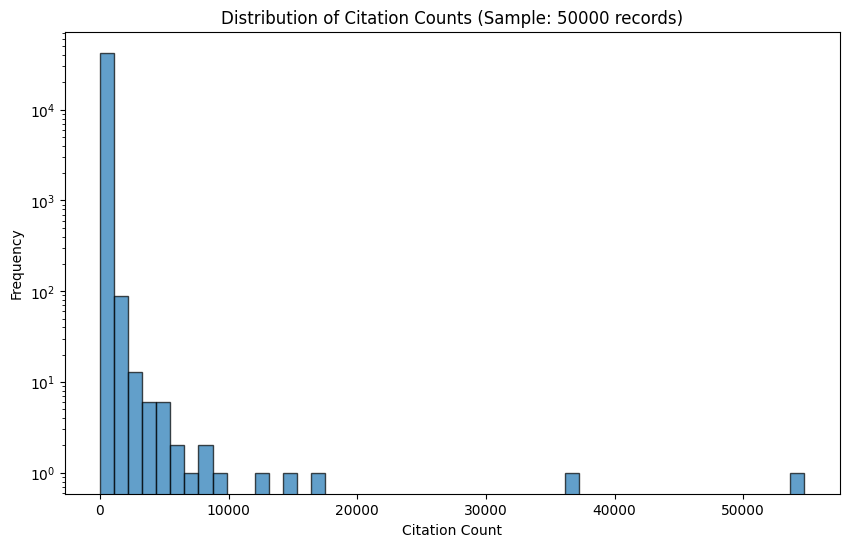

2025-08-28 03:55:34,976 - INFO - [MEM: 4804.2MB] - Analyzing publication years...
2025-08-28 03:55:35,042 - INFO - [MEM: 4804.2MB] - Year statistics:
count    1.732750e+06
mean     2.004538e+03
std      1.014931e+01
min      0.000000e+00
25%      2.001000e+03
50%      2.007000e+03
75%      2.011000e+03
max      2.022000e+03
Name: year, dtype: float64
2025-08-28 03:55:35,043 - INFO - [MEM: 4804.2MB] - Analyzing text fields...
2025-08-28 03:55:35,043 - INFO - [MEM: 4804.2MB] - Analyzing title...


Memory: 4590.1MB -> 4648.7MB (freed: -58.6MB)


2025-08-28 03:55:35,252 - INFO - [MEM: 4804.2MB] - title length statistics (sample):
count    1000.000000
mean       75.714000
std        59.453502
min         7.000000
25%        51.000000
50%        68.000000
75%        87.000000
max       926.000000
Name: title, dtype: float64
2025-08-28 03:55:35,253 - INFO - [MEM: 4804.2MB] - Analyzing abstract...
2025-08-28 03:55:35,629 - INFO - [MEM: 4804.2MB] - abstract length statistics (sample):
count    1000.000000
mean      871.858000
std       433.127937
min         1.000000
25%       582.750000
50%       832.000000
75%      1120.000000
max      2859.000000
Name: abstract, dtype: float64
2025-08-28 03:55:35,629 - INFO - [MEM: 4804.2MB] - Analyzing keywords...
2025-08-28 03:55:35,849 - INFO - [MEM: 4804.2MB] - keywords length statistics (sample):
count    1000.000000
mean      195.489000
std       180.631286
min         2.000000
25%        44.000000
50%       139.500000
75%       315.000000
max      1011.000000
Name: keywords, dtype: float64

EDA completed. Memory usage: 4679.3MB

Top columns with missing values:
          Missing_Count  Missing_Percentage
isbn            1648056           81.275749
issue           1186867           58.531691
issn            1027093           50.652255
volume           940837           46.398443
abstract         610654           30.115094

Citation count statistics:
count    1.732752e+06
mean     3.947402e+01
std      3.290488e+02
min      0.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.600000e+01
max      1.218600e+05
Name: n_citation, dtype: float64


In [3]:


# ============================================================================
# BLOCK 3: Memory-Efficient Exploratory Data Analysis
# ============================================================================

def perform_memory_efficient_eda(df: pd.DataFrame) -> Dict[str, Any]:
    """Perform EDA with memory efficiency in mind"""
    logger = setup_logging("eda")
    logger.info("Starting Memory-Efficient EDA")
    
    eda_results = {}
    
    try:
        # Basic info
        logger.info(f"Dataset shape: {df.shape}")
        logger.info(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
        
        # Missing values analysis
        logger.info("Analyzing missing values...")
        missing_info = df.isnull().sum()
        missing_pct = (missing_info / len(df)) * 100
        
        missing_df = pd.DataFrame({
            'Missing_Count': missing_info,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Percentage', ascending=False)
        
        eda_results['missing_values'] = missing_df[missing_df['Missing_Count'] > 0]
        logger.info(f"Columns with missing values: {len(eda_results['missing_values'])}")
        
        # Target variable analysis (n_citation)
        if 'n_citation' in df.columns:
            logger.info("Analyzing target variable (n_citation)...")
            df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')
            
            citation_stats = df['n_citation'].describe()
            eda_results['citation_stats'] = citation_stats
            logger.info(f"Citation statistics:\n{citation_stats}")
            
            # Create histogram efficiently (sample if dataset is large)
            sample_size = min(50000, len(df))
            sample_df = df.sample(n=sample_size, random_state=CONFIG['RANDOM_STATE'])
            
            plt.figure(figsize=(10, 6))
            plt.hist(sample_df['n_citation'].dropna(), bins=50, alpha=0.7, edgecolor='black')
            plt.title(f'Distribution of Citation Counts (Sample: {sample_size} records)')
            plt.xlabel('Citation Count')
            plt.ylabel('Frequency')
            plt.yscale('log')  # Log scale due to typical skewness
            plt.show()
            
            del sample_df
            force_garbage_collection()
        
        # Year analysis
        if 'year' in df.columns:
            logger.info("Analyzing publication years...")
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
            year_stats = df['year'].describe()
            eda_results['year_stats'] = year_stats
            logger.info(f"Year statistics:\n{year_stats}")
        
        # Text field analysis (sample-based to save memory)
        text_cols = ['title', 'abstract', 'keywords']
        logger.info("Analyzing text fields...")
        
        for col in text_cols:
            if col in df.columns:
                logger.info(f"Analyzing {col}...")
                
                # Sample for analysis
                sample_texts = df[col].dropna().sample(min(1000, df[col].dropna().shape[0]), 
                                                     random_state=CONFIG['RANDOM_STATE'])
                
                if col == 'keywords':
                    # Special handling for keywords
                    sample_lengths = sample_texts.apply(lambda x: len(str(x)))
                else:
                    sample_lengths = sample_texts.str.len()
                
                eda_results[f'{col}_length_stats'] = sample_lengths.describe()
                logger.info(f"{col} length statistics (sample):\n{sample_lengths.describe()}")
        
        logger.info("EDA completed successfully")
        return eda_results
        
    except Exception as e:
        logger.error(f"Error during EDA: {e}", exc_info=True)
        raise

# Perform EDA
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

eda_results = perform_memory_efficient_eda(df)
print(f"EDA completed. Memory usage: {get_memory_usage():.1f}MB")

# Display key findings
if 'missing_values' in eda_results and not eda_results['missing_values'].empty:
    print("\nTop columns with missing values:")
    print(eda_results['missing_values'].head())

if 'citation_stats' in eda_results:
    print(f"\nCitation count statistics:")
    print(eda_results['citation_stats'])

In [4]:

# ============================================================================
# BLOCK 4: Memory-Efficient Data Cleaning
# ============================================================================

import ast
import re
from typing import List, Union

import re

def robust_keyword_parser(keyword_input: Union[str, list, None]) -> List[str]:
    """Robustly parse keywords with memory efficiency and escape issues fixed"""
    if pd.isna(keyword_input) or keyword_input in ['[]', '{}', 'None', 'none', 'null', '']:
        return []
    
    if isinstance(keyword_input, list):
        return clean_keyword_list(keyword_input)
    
    keyword_str = str(keyword_input).strip()

    # Escape invalid backslashes to avoid SyntaxWarnings
    keyword_str = re.sub(r'\\(?![nrt\\"])', r'\\\\', keyword_str)

    # Try parsing as literal
    if keyword_str.startswith('[') and keyword_str.endswith(']'):
        try:
            parsed = ast.literal_eval(keyword_str)
            if isinstance(parsed, list):
                return clean_keyword_list(parsed)
        except (ValueError, SyntaxError):
            pass

    # Fallback to comma separation
    if ',' in keyword_str:
        keywords = [kw.strip() for kw in keyword_str.split(',')]
        return clean_keyword_list(keywords)
    
    # Space separation as last resort
    keywords = keyword_str.split()
    return clean_keyword_list(keywords)


def clean_keyword_list(keyword_list: List[Union[str, int, float]]) -> List[str]:
    """Clean individual keywords in a list"""
    cleaned = []
    blacklist = {'', 'none', 'null', 'na', 'n/a', 'keyword', 'keywords', 'none type'}
    
    for kw in keyword_list:
        if pd.isna(kw):
            continue
            
        kw_str = str(kw).strip().lower()
        kw_str = re.sub(r'[^\w\s\-]', '', kw_str)  # Escaped hyphen

        
        if (len(kw_str) > 1 and 
            not kw_str.isnumeric() and 
            kw_str not in blacklist):
            cleaned.append(kw_str)
    
    return list(set(cleaned))

def clean_data_efficiently(df: pd.DataFrame) -> pd.DataFrame:
    """Clean data with memory optimization"""
    logger = setup_logging("data_cleaning")
    logger.info(f"Starting data cleaning on {len(df)} records")
    
    initial_memory = get_memory_usage()
    
    try:
        # Drop unnecessary columns
        # Fix for NameError: Define the list, even if empty.
        columns_to_drop = []
        existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
        if existing_cols_to_drop:
            df = df.drop(columns=existing_cols_to_drop)
            logger.info(f"Dropped columns: {existing_cols_to_drop}")
            force_garbage_collection()
        
        # Handle target variable (n_citation)
        if 'n_citation' in df.columns:
            initial_len = len(df)
            # Use .loc to avoid SettingWithCopyWarning
            df.loc[:, 'n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')
            
            # This is the correct way to drop NaNs and ensure we have a new DataFrame
            df = df.dropna(subset=['n_citation']).copy()
            
            # This assignment is now on a guaranteed copy, but .loc is still best practice.
            df.loc[:, 'n_citation'] = df['n_citation'].astype(CONFIG['DTYPE_OPTIMIZATIONS']['n_citation'])
            logger.info(f"Removed {initial_len - len(df)} rows with missing citations")
        
        # Handle year
        if 'year' in df.columns:
            # Use .loc to avoid SettingWithCopyWarning
            df.loc[:, 'year'] = pd.to_numeric(df['year'], errors='coerce')
            mode_year = int(df['year'].mode()[0]) if not df['year'].mode().empty else 2000
            df.loc[:, 'year'] = df['year'].fillna(mode_year).astype(CONFIG['DTYPE_OPTIMIZATIONS']['year'])
            logger.info(f"Filled missing years with mode: {mode_year}")
        
        # Process keywords in chunks to manage memory (already uses .loc, which is good)
        if 'keywords' in df.columns:
            logger.info("Processing keywords...")
            chunk_size = 5000

            for i in range(0, len(df), chunk_size):
                chunk_end = min(i + chunk_size, len(df))
                df.loc[df.index[i:chunk_end], 'keywords'] = df['keywords'].iloc[i:chunk_end].apply(robust_keyword_parser)

                if i % 20000 == 0:  # Progress update every 20k records
                    logger.info(f"Processed keywords for {chunk_end}/{len(df)} records")
                    check_memory_limit(CONFIG['MAX_MEMORY_MB'])

            logger.info("Keywords processing completed")
            force_garbage_collection()

        
        # Clean text fields efficiently using .loc
        text_cols = ['title', 'abstract', 'venue', 'doc_type']
        for col in text_cols:
            if col in df.columns:
                df.loc[:, col] = df[col].fillna("").astype(str).str.strip().str.lower()
                df.loc[:, col] = df[col].replace({'none': '', 'null': '', 'nan': ''})
                logger.info(f"Cleaned text column: {col}")
        
        # Handle references using .loc
        if 'references' in df.columns:
            logger.info("Processing references...")
            def safe_reference_parser(ref):
                if isinstance(ref, list):
                    return ref
                try:
                    if isinstance(ref, str) and ref.startswith('['):
                        return ast.literal_eval(ref)
                except Exception:
                    return []
                return []
            df.loc[:, 'references'] = df['references'].apply(safe_reference_parser)
            logger.info("References processed")
        
        # Memory optimization - convert to optimal dtypes using .loc
        for col, dtype in CONFIG['DTYPE_OPTIMIZATIONS'].items():
            if col in df.columns:
                df.loc[:, col] = df[col].astype(dtype)
        
        logger.info(f"Data cleaning completed. Shape: {df.shape}")
        logger.info(f"Memory usage: {initial_memory:.1f}MB -> {get_memory_usage():.1f}MB")
        
        return df
        
    except Exception as e:
        logger.error(f"Error during data cleaning: {e}", exc_info=True)
        raise

# Clean data
print("\n" + "="*50)
print("DATA CLEANING")
print("="*50)

df_clean = clean_data_efficiently(df)
print(f"Data cleaning completed. Final shape: {df_clean.shape}")
print(f"Memory usage after cleaning: {get_memory_usage():.1f}MB")



2025-08-28 03:55:35,865 - INFO - [MEM: 4680.0MB] - Starting data cleaning on 2027734 records



DATA CLEANING


2025-08-28 03:55:38,741 - INFO - [MEM: 4680.0MB] - Removed 294982 rows with missing citations
2025-08-28 03:55:38,784 - INFO - [MEM: 4680.0MB] - Filled missing years with mode: 2012
2025-08-28 03:55:38,785 - INFO - [MEM: 4680.0MB] - Processing keywords...
2025-08-28 03:55:38,940 - INFO - [MEM: 4680.0MB] - Processed keywords for 5000/1732752 records
2025-08-28 03:55:39,364 - INFO - [MEM: 4680.0MB] - Processed keywords for 25000/1732752 records
2025-08-28 03:55:39,875 - INFO - [MEM: 4680.0MB] - Processed keywords for 45000/1732752 records
2025-08-28 03:55:40,536 - INFO - [MEM: 4680.0MB] - Processed keywords for 65000/1732752 records
2025-08-28 03:55:41,200 - INFO - [MEM: 4680.0MB] - Processed keywords for 85000/1732752 records
2025-08-28 03:55:41,875 - INFO - [MEM: 4680.0MB] - Processed keywords for 105000/1732752 records
2025-08-28 03:55:42,618 - INFO - [MEM: 4680.0MB] - Processed keywords for 125000/1732752 records
2025-08-28 03:55:43,293 - INFO - [MEM: 4680.0MB] - Processed keywords f

Memory: 5980.5MB -> 5980.5MB (freed: 0.0MB)


2025-08-28 03:56:38,078 - INFO - [MEM: 4680.0MB] - Cleaned text column: title
2025-08-28 03:56:42,413 - INFO - [MEM: 4680.0MB] - Cleaned text column: abstract
2025-08-28 03:56:43,792 - INFO - [MEM: 4680.0MB] - Cleaned text column: venue
2025-08-28 03:56:44,347 - INFO - [MEM: 4680.0MB] - Cleaned text column: doc_type
2025-08-28 03:56:44,347 - INFO - [MEM: 4680.0MB] - Processing references...
2025-08-28 03:57:11,864 - INFO - [MEM: 4680.0MB] - References processed
2025-08-28 03:57:11,910 - INFO - [MEM: 4680.0MB] - Data cleaning completed. Shape: (1732752, 19)
2025-08-28 03:57:11,911 - INFO - [MEM: 4680.0MB] - Memory usage: 4680.0MB -> 4516.2MB


Data cleaning completed. Final shape: (1732752, 19)
Memory usage after cleaning: 4516.7MB


In [5]:
# Save cleaned data
cleaned_path = CONFIG['DATA_DIR'] / CONFIG['CLEANED_PARQUET_FILE']
df_clean.to_parquet(cleaned_path, index=False)
print(f"Cleaned data saved to: {cleaned_path}")

# Free memory
del df
force_garbage_collection()

Cleaned data saved to: dblp_cleaned.parquet
Memory: 3959.8MB -> 3280.8MB (freed: 678.9MB)


In [6]:


# ============================================================================
# BLOCK 5: Memory-Efficient Feature Engineering - Numerical Features
# ============================================================================

def create_numerical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create numerical features efficiently"""
    logger = setup_logging("numerical_features")
    logger.info("Creating numerical features")
    
    try:
        # Title length
        if 'title' in df.columns:
            df['title_length'] = df['title'].astype(str).str.len().astype(CONFIG['DTYPE_OPTIMIZATIONS']['title_length'])
            logger.info("Created title_length feature")
        else:
            df['title_length'] = 0
            logger.warning("Title column not found, defaulting title_length to 0")
        
        # Abstract length
        if 'abstract' in df.columns:
            df['abstract_length'] = df['abstract'].astype(str).str.len().astype(CONFIG['DTYPE_OPTIMIZATIONS']['abstract_length'])
            logger.info("Created abstract_length feature")
        else:
            df['abstract_length'] = 0
            logger.warning("Abstract column not found, defaulting abstract_length to 0")
        
        # Number of keywords
        if 'keywords' in df.columns:
            df['num_keywords'] = df['keywords'].apply(len).astype(CONFIG['DTYPE_OPTIMIZATIONS']['num_keywords'])
            logger.info("Created num_keywords feature")
        else:
            df['num_keywords'] = 0
            logger.warning("Keywords column not found, defaulting num_keywords to 0")
        
        # Age of publication
        if 'year' in df.columns:
            current_year = pd.Timestamp.now().year
            df['age'] = (current_year - df['year']).clip(lower=0).astype(CONFIG['DTYPE_OPTIMIZATIONS']['age'])
            logger.info("Created age feature")
        else:
            df['age'] = 0
            logger.warning("Year column not found, defaulting age to 0")
        
        # Number of references
        if 'references' in df.columns:
            df['num_references'] = df['references'].apply(len).astype(CONFIG['DTYPE_OPTIMIZATIONS']['num_references'])
            logger.info("Created num_references feature")
        else:
            df['num_references'] = 0
            logger.warning("References column not found, defaulting num_references to 0")
        
        # Boolean features
        df['has_doi'] = df['doi'].notna().astype(CONFIG['DTYPE_OPTIMIZATIONS']['has_doi']) if 'doi' in df.columns else 0
        df['has_url'] = df['url'].notna().astype(CONFIG['DTYPE_OPTIMIZATIONS']['has_url']) if 'url' in df.columns else 0
        
        logger.info("All numerical features created successfully")
        return df
        
    except Exception as e:
        logger.error(f"Error creating numerical features: {e}", exc_info=True)
        raise

# Create numerical features
print("\n" + "="*50)
print("CREATING NUMERICAL FEATURES")
print("="*50)

df_features = create_numerical_features(df_clean)
print(f"Numerical features created. Memory usage: {get_memory_usage():.1f}MB")

# Verify numerical features
print("\nNumerical feature statistics:")
for col in NUMERICAL_FEATURES_COLS:
    if col in df_features.columns:
        stats = df_features[col].describe()
        print(f"{col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, max={stats['max']}")

2025-08-28 03:57:50,798 - INFO - [MEM: 3289.5MB] - Creating numerical features



CREATING NUMERICAL FEATURES


2025-08-28 03:57:51,865 - INFO - [MEM: 3289.5MB] - Created title_length feature
2025-08-28 03:57:52,808 - INFO - [MEM: 3289.5MB] - Created abstract_length feature
2025-08-28 03:57:53,255 - INFO - [MEM: 3289.5MB] - Created num_keywords feature
2025-08-28 03:57:53,279 - INFO - [MEM: 3289.5MB] - Created age feature
2025-08-28 03:57:53,675 - INFO - [MEM: 3289.5MB] - Created num_references feature
2025-08-28 03:57:54,604 - INFO - [MEM: 3289.5MB] - All numerical features created successfully


Numerical features created. Memory usage: 5618.5MB

Numerical feature statistics:
title_length: mean=70.25, std=27.32, max=900.0
abstract_length: mean=708.48, std=572.34, max=72632.0
num_keywords: mean=8.87, std=7.88, max=141.0
age: mean=20.46, std=10.15, max=2025.0
num_references: mean=7.44, std=10.37, max=1930.0
has_doi: mean=0.82, std=0.38, max=1.0
has_url: mean=1.00, std=0.06, max=1.0


In [7]:
# ============================================================================
# BLOCK 5.5: Advanced Feature Engineering (Venue & Author)
# ============================================================================

def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create more powerful features from venue and authors."""
    logger = setup_logging("advanced_features")
    logger.info("Creating advanced features (venue quality, author count)")

    try:
        # 1. Venue Quality Score (based on mean citations)
        if 'venue' in df.columns and 'n_citation' in df.columns:
            logger.info("Calculating venue quality scores...")
            # Calculate mean citation per venue
            venue_quality = df.groupby('venue')['n_citation'].mean().to_dict()
            
            # Map this back to the dataframe
            df['venue_quality_score'] = df['venue'].map(venue_quality)
            
            # Fill missing venues with the global median citation count
            global_median_citation = df['n_citation'].median()
            df['venue_quality_score'].fillna(global_median_citation, inplace=True)
            
            df['venue_quality_score'] = df['venue_quality_score'].astype('float32')
            logger.info("Venue quality score created.")
        else:
            logger.warning("Skipping venue quality score (venue or n_citation column missing).")
            df['venue_quality_score'] = 0.0

        # 2. Number of Authors
        if 'authors' in df.columns:
            logger.info("Calculating number of authors...")
            # The 'authors' column is a string representation of a list
            def count_authors(authors_str):
                if pd.isna(authors_str) or not isinstance(authors_str, str) or not authors_str.strip():
                    return 1 # Default to 1 author if data is missing/malformed
                try:
                    # Use a simple comma split as a robust fallback
                    return len(authors_str.split(','))
                except:
                    return 1
            
            df['num_authors'] = df['authors'].apply(count_authors).astype('int16')
            logger.info("Number of authors feature created.")
        else:
            logger.warning("Skipping author count (authors column missing).")
            df['num_authors'] = 1

        return df

    except Exception as e:
        logger.error(f"Error creating advanced features: {e}", exc_info=True)
        raise

# Add the new features
print("\n" + "="*50)
print("CREATING ADVANCED FEATURES")
print("="*50)

df_features = create_advanced_features(df_features)

# Add new features to the list of numerical columns for the model
NEW_NUMERICAL_COLS = ['venue_quality_score', 'num_authors']
for col in NEW_NUMERICAL_COLS:
    if col not in NUMERICAL_FEATURES_COLS:
        NUMERICAL_FEATURES_COLS.append(col)

print(f"Advanced features created. Memory usage: {get_memory_usage():.1f}MB")
print("\nUpdated list of numerical features:")
print(NUMERICAL_FEATURES_COLS)

2025-08-28 03:57:54,816 - INFO - [MEM: 5581.2MB] - Creating advanced features (venue quality, author count)
2025-08-28 03:57:54,817 - INFO - [MEM: 5581.2MB] - Calculating venue quality scores...



CREATING ADVANCED FEATURES


2025-08-28 03:57:55,664 - INFO - [MEM: 5581.2MB] - Venue quality score created.
2025-08-28 03:57:55,665 - INFO - [MEM: 5581.2MB] - Calculating number of authors...
2025-08-28 03:57:59,256 - INFO - [MEM: 5581.2MB] - Number of authors feature created.


Advanced features created. Memory usage: 2022.2MB

Updated list of numerical features:
['title_length', 'abstract_length', 'num_keywords', 'age', 'num_references', 'has_doi', 'has_url', 'venue_quality_score', 'num_authors']


In [8]:


# ============================================================================
# BLOCK 6: Memory-Efficient TF-IDF Feature Engineering
# ============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, coo_matrix, save_npz, csr_matrix
import joblib

def create_tfidf_features_efficiently(df: pd.DataFrame) -> tuple:
    """Create TF-IDF features with memory optimization"""
    logger = setup_logging("tfidf_features")
    logger.info("Starting TF-IDF feature creation")
    
    vectorizers = {}
    sparse_features = []
    
    try:
        # Process each text field separately to manage memory
        text_fields = ['title', 'abstract', 'keywords']
        
        for field in text_fields:
            logger.info(f"Processing TF-IDF for {field}...")
            
            if field not in df.columns:
                logger.warning(f"{field} column not found, skipping")
                sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
                continue
            
            try:
                # Prepare text data
                if field == 'keywords':
                    text_data = df[field].apply(
                        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
                    ).fillna('')
                else:
                    text_data = df[field].astype(str).fillna('')
                
                # Check for empty documents
                non_empty_mask = text_data.str.strip().astype(bool)
                non_empty_count = non_empty_mask.sum()
                
                if non_empty_count == 0:
                    logger.warning(f"All {field} documents are empty")
                    sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
                    continue
                
                # Configure vectorizer based on field
                if field == 'keywords':
                    vectorizer = TfidfVectorizer(
                        max_features=CONFIG['TFIDF_MAX_FEATURES'] // 2,  # Smaller for keywords
                        min_df=CONFIG['TFIDF_MIN_DF_KEYWORDS'],
                        ngram_range=(1, 1),  # Only unigrams for keywords
                        stop_words=None,
                        token_pattern=r'\S+',
                        dtype=np.float32  # Use float32 to save memory
                    )
                else:
                    vectorizer = TfidfVectorizer(
                        max_features=CONFIG['TFIDF_MAX_FEATURES'],
                        min_df=CONFIG['TFIDF_MIN_DF_TITLE_ABSTRACT'],
                        ngram_range=CONFIG['TFIDF_NGRAM_RANGE'],
                        stop_words='english',
                        dtype=np.float32
                    )
                
                # Fit and transform
                tfidf_matrix = vectorizer.fit_transform(text_data)
                
                # Convert to CSR for efficiency
                if not isinstance(tfidf_matrix, csr_matrix):
                    tfidf_matrix = tfidf_matrix.tocsr()
                
                sparse_features.append(tfidf_matrix)
                vectorizers[field] = vectorizer
                
                logger.info(f"{field} TF-IDF shape: {tfidf_matrix.shape}, "
                           f"sparsity: {1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]):.4f}")
                
                # Clean up temporary variables
                del text_data, tfidf_matrix
                check_memory_limit(CONFIG['MAX_MEMORY_MB'])
                
            except Exception as e:
                logger.error(f"Error processing {field}: {e}")
                sparse_features.append(coo_matrix((len(df), 0), dtype=np.float32))
        
        # Combine sparse features efficiently
        logger.info("Combining sparse features...")
        if sparse_features:
            combined_features = hstack(sparse_features, format='csr', dtype=np.float32)
            logger.info(f"Combined TF-IDF features shape: {combined_features.shape}")
        else:
            combined_features = coo_matrix((len(df), 0), dtype=np.float32)
            logger.warning("No TF-IDF features generated")
        
        return combined_features, vectorizers
        
    except Exception as e:
        logger.error(f"Error in TF-IDF feature creation: {e}", exc_info=True)
        raise

# Create TF-IDF features
print("\n" + "="*50)
print("CREATING TF-IDF FEATURES")
print("="*50)

combined_tfidf, vectorizers = create_tfidf_features_efficiently(df_features)
print(f"TF-IDF features created. Shape: {combined_tfidf.shape}")
print(f"Memory usage: {get_memory_usage():.1f}MB")

# Save TF-IDF features and vectorizers for the next steps
print("Saving TF-IDF features and vectorizers...")
save_npz(CONFIG['TFIDF_COMBINED_FEATURES_PATH'], combined_tfidf)
print(f"TF-IDF features saved to: {CONFIG['TFIDF_COMBINED_FEATURES_PATH']}")
joblib.dump(vectorizers, CONFIG['VECTORIZERS_PATH'])
print(f"Vectorizers saved to: {CONFIG['VECTORIZERS_PATH']}")

2025-08-28 03:58:00,217 - INFO - [MEM: 2904.1MB] - Starting TF-IDF feature creation
2025-08-28 03:58:00,217 - INFO - [MEM: 2904.1MB] - Processing TF-IDF for title...



CREATING TF-IDF FEATURES


2025-08-28 03:58:34,140 - INFO - [MEM: 2904.1MB] - title TF-IDF shape: (1732752, 5000), sparsity: 0.9987
2025-08-28 03:58:34,142 - INFO - [MEM: 2904.1MB] - Processing TF-IDF for abstract...
2025-08-28 04:04:17,387 - INFO - [MEM: 2904.1MB] - abstract TF-IDF shape: (1732752, 5000), sparsity: 0.9917
2025-08-28 04:04:17,390 - INFO - [MEM: 2904.1MB] - Processing TF-IDF for keywords...
2025-08-28 04:04:40,805 - INFO - [MEM: 2904.1MB] - keywords TF-IDF shape: (1732752, 2500), sparsity: 0.9953
2025-08-28 04:04:40,806 - INFO - [MEM: 2904.1MB] - Combining sparse features...
2025-08-28 04:04:41,356 - INFO - [MEM: 2904.1MB] - Combined TF-IDF features shape: (1732752, 12500)


TF-IDF features created. Shape: (1732752, 12500)
Memory usage: 4307.3MB
Saving TF-IDF features and vectorizers...
TF-IDF features saved to: tfidf_combined_sparse_features.npz
Vectorizers saved to: tfidf_vectorizers.pkl


In [9]:
# ============================================================================
# BLOCK 6.5: Topic Modeling (LDA) Features
# ============================================================================
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def create_lda_features(df: pd.DataFrame, config: Dict) -> tuple:
    """
    Create topic modeling features using Latent Dirichlet Allocation (LDA).
    Includes logging, error handling, and saves the trained models.
    """
    logger = setup_logging("lda_features")
    logger.info("Starting LDA feature creation")

    try:
        if 'abstract' not in df.columns or df['abstract'].str.strip().eq('').all():
            logger.warning("Abstract column is missing or all entries are empty. Skipping LDA.")
            return pd.DataFrame(index=df.index), []

        # 1. Create a document-term matrix using CountVectorizer
        logger.info("Creating document-term matrix with CountVectorizer for LDA...")
        text_data = df['abstract'].astype(str).fillna('')

        lda_vectorizer = CountVectorizer(
            max_df=config['LDA_MAX_DF'],
            min_df=config['LDA_MIN_DF'],
            max_features=config['LDA_MAX_FEATURES'],
            stop_words='english',
            dtype=np.int32
        )

        doc_term_matrix = lda_vectorizer.fit_transform(text_data)
        logger.info(f"Document-term matrix shape for LDA: {doc_term_matrix.shape}")

        # 2. Fit the LDA model
        n_topics = config['LDA_N_TOPICS']
        logger.info(f"Fitting LDA model with {n_topics} topics...")
        
        lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=config['RANDOM_STATE'],
            n_jobs=config['N_JOBS'],
            learning_method='online', # More memory efficient
            batch_size=128,
            verbose=0 # Keep console clean, rely on our logs
        )
        
        topic_distributions = lda_model.fit_transform(doc_term_matrix)
        logger.info(f"LDA topic distributions created. Shape: {topic_distributions.shape}")

        # 3. Create topic feature columns
        topic_columns = [f'topic_{i}' for i in range(n_topics)]
        df_topics = pd.DataFrame(topic_distributions, columns=topic_columns, index=df.index)
        for col in topic_columns:
            df_topics[col] = df_topics[col].astype(np.float32)

        # 4. Save the LDA model and its vectorizer
        logger.info("Saving LDA model and CountVectorizer...")
        joblib.dump(lda_model, config['LDA_MODEL_PATH'])
        joblib.dump(lda_vectorizer, config['LDA_VECTORIZER_PATH'])
        logger.info(f"LDA model saved to: {config['LDA_MODEL_PATH']}")
        logger.info(f"LDA CountVectorizer saved to: {config['LDA_VECTORIZER_PATH']}")

        return df_topics, topic_columns

    except Exception as e:
        logger.error(f"Critical error during LDA feature creation: {e}", exc_info=True)
        return pd.DataFrame(index=df.index), []

# --- Add LDA features to the main dataframe ---
print("\n" + "="*50)
print("CREATING TOPIC MODELING (LDA) FEATURES")
print("="*50)

df_topic_features, topic_cols = create_lda_features(df_features, CONFIG)

if not df_topic_features.empty:
    df_features = df_features.join(df_topic_features)
    for col in topic_cols:
        if col not in NUMERICAL_FEATURES_COLS:
            NUMERICAL_FEATURES_COLS.append(col)
    print(f"LDA topic features created. New dataframe shape: {df_features.shape}")
    print(f"Memory usage: {get_memory_usage():.1f}MB")
else:
    print("LDA feature creation was skipped or failed. Continuing without topic features.")

2025-08-28 04:05:35,450 - INFO - [MEM: 6380.3MB] - Starting LDA feature creation



CREATING TOPIC MODELING (LDA) FEATURES


2025-08-28 04:05:35,956 - INFO - [MEM: 6380.3MB] - Creating document-term matrix with CountVectorizer for LDA...
2025-08-28 04:06:47,530 - INFO - [MEM: 6380.3MB] - Document-term matrix shape for LDA: (1732752, 5000)
2025-08-28 04:06:47,531 - INFO - [MEM: 6380.3MB] - Fitting LDA model with 10 topics...
2025-08-28 04:46:00,947 - INFO - [MEM: 6380.3MB] - LDA topic distributions created. Shape: (1732752, 10)
2025-08-28 04:46:00,990 - INFO - [MEM: 6380.3MB] - Saving LDA model and CountVectorizer...
2025-08-28 04:46:01,039 - INFO - [MEM: 6380.3MB] - LDA model saved to: lda_model.pkl
2025-08-28 04:46:01,040 - INFO - [MEM: 6380.3MB] - LDA CountVectorizer saved to: lda_count_vectorizer.pkl


LDA topic features created. New dataframe shape: (1732752, 38)
Memory usage: 3066.7MB


In [10]:


# ============================================================================
# BLOCK 7: Final Data Preparation and Saving
# ============================================================================

def finalize_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Final dataset preparation with memory optimization"""
    logger = setup_logging("finalize_dataset")
    logger.info("Finalizing dataset")
    
    try:
        # Ensure all numerical features exist with correct dtypes
        for col in NUMERICAL_FEATURES_COLS:
            if col in df.columns:
                if col in CONFIG['DTYPE_OPTIMIZATIONS']:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                    df[col] = df[col].astype(CONFIG['DTYPE_OPTIMIZATIONS'][col])
            else:
                # Add missing feature with default value
                default_dtype = CONFIG['DTYPE_OPTIMIZATIONS'].get(col, 'float32')
                df[col] = pd.Series(0, index=df.index, dtype=default_dtype)
                logger.warning(f"Added missing feature {col} with default value 0")
        
        # Final data quality checks
        logger.info("Performing final data quality checks...")
        
        # Check for infinite values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        inf_counts = {}
        for col in numeric_cols:
            inf_count = np.isinf(df[col]).sum()
            if inf_count > 0:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(df[col].median())
                inf_counts[col] = inf_count
        
        if inf_counts:
            logger.warning(f"Replaced infinite values in columns: {inf_counts}")
        
        # Final memory optimization
        memory_before = df.memory_usage(deep=True).sum() / 1024**2
        
        # Optimize string columns
        string_cols = df.select_dtypes(include=['object']).columns
        for col in string_cols:

        # Optimize string columns
            string_cols = df.select_dtypes(include=['object']).columns
            for col in string_cols:
                if col in ['title', 'abstract', 'venue', 'doc_type', 'lang']:
                    unique_ratio = df[col].nunique() / len(df)
                    if unique_ratio < 0.1:  # Less than 10% unique values
                        df[col] = df[col].astype('category')
                        logger.info(f"Converted {col} to category dtype")
            
            memory_after = df.memory_usage(deep=True).sum() / 1024**2
            logger.info(f"Memory optimization: {memory_before:.1f}MB -> {memory_after:.1f}MB")
            
            # Final dataset summary
            logger.info(f"Final dataset shape: {df.shape}")
            logger.info(f"Target variable (n_citation) range: {df['n_citation'].min()} - {df['n_citation'].max()}")
            logger.info(f"Available features: {list(df.columns)}")
            
            return df
        
    except Exception as e:
        logger.error(f"Error finalizing dataset: {e}", exc_info=True)
        raise

# Finalize the dataset
print("\n" + "="*50)
print("FINALIZING DATASET")
print("="*50)

df_final = finalize_dataset(df_features)
print(f"Dataset finalized. Shape: {df_final.shape}")
print(f"Memory usage: {get_memory_usage():.1f}MB")

# Save the final processed dataset
final_processed_path = CONFIG['DATA_DIR'] / 'dblp_final_processed.parquet'
df_final.to_parquet(final_processed_path, index=False)
print(f"Final processed dataset saved to: {final_processed_path}")

# Create a summary of numerical features for later use
numerical_summary = df_final[NUMERICAL_FEATURES_COLS].describe()
summary_path = CONFIG['DATA_DIR'] / 'numerical_features_summary.csv'
numerical_summary.to_csv(summary_path)
print(f"Numerical features summary saved to: {summary_path}")

2025-08-28 04:46:10,011 - INFO - [MEM: 3083.2MB] - Finalizing dataset
2025-08-28 04:46:10,028 - INFO - [MEM: 3083.2MB] - Performing final data quality checks...



FINALIZING DATASET


2025-08-28 04:46:28,450 - INFO - [MEM: 3083.2MB] - Converted lang to category dtype
2025-08-28 04:46:28,799 - INFO - [MEM: 3083.2MB] - Converted venue to category dtype
2025-08-28 04:46:33,327 - INFO - [MEM: 3083.2MB] - Converted doc_type to category dtype
2025-08-28 04:46:38,924 - INFO - [MEM: 3083.2MB] - Memory optimization: 4459.8MB -> 4152.6MB
2025-08-28 04:46:38,929 - INFO - [MEM: 3083.2MB] - Final dataset shape: (1732752, 38)
2025-08-28 04:46:38,939 - INFO - [MEM: 3083.2MB] - Target variable (n_citation) range: 0.0 - 121860.0
2025-08-28 04:46:38,940 - INFO - [MEM: 3083.2MB] - Available features: ['id', 'title', 'doi', 'issue', 'keywords', 'lang', 'venue', 'year', 'n_citation', 'page_start', 'page_end', 'volume', 'issn', 'isbn', 'url', 'abstract', 'authors', 'doc_type', 'references', 'title_length', 'abstract_length', 'num_keywords', 'age', 'num_references', 'has_doi', 'has_url', 'venue_quality_score', 'num_authors', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5'

Dataset finalized. Shape: (1732752, 38)
Memory usage: 6621.0MB
Final processed dataset saved to: dblp_final_processed.parquet
Numerical features summary saved to: numerical_features_summary.csv


In [11]:


# ============================================================================
# BLOCK 8: Memory-Efficient Train-Test Split
# ============================================================================

from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz

def create_train_test_split_efficiently(df: pd.DataFrame, test_size: float = 0.2) -> tuple:
    """Create train-test split with memory efficiency"""
    logger = setup_logging("train_test_split")
    logger.info(f"Creating train-test split with test_size={test_size}")
    
    try:
        # Prepare target variable
        # Prepare target variable with log1p transform (for better regression)
        y = np.log1p(df['n_citation'].values)
        logger.info(f"Target (log1p) statistics: min={y.min()}, max={y.max()}, mean={y.mean():.2f}")

        
        # Prepare numerical features
        X_numerical = df[NUMERICAL_FEATURES_COLS].values.astype(np.float32)
        logger.info(f"Numerical features shape: {X_numerical.shape}")
        
        # Load TF-IDF features
        logger.info("Loading TF-IDF features...")
        X_tfidf = load_npz(CONFIG['TFIDF_COMBINED_FEATURES_PATH'])
        logger.info(f"TF-IDF features shape: {X_tfidf.shape}")
        
        # Combine features
        logger.info("Combining numerical and TF-IDF features...")
        X_numerical_sparse = csr_matrix(X_numerical, dtype=np.float32)
        X_combined = hstack([X_numerical_sparse, X_tfidf], format='csr', dtype=np.float32)
        
        logger.info(f"Combined features shape: {X_combined.shape}")
        logger.info(f"Combined features sparsity: {1 - X_combined.nnz / (X_combined.shape[0] * X_combined.shape[1]):.4f}")
        
        # Stratified split for better distribution
        # Create stratification bins for continuous target
        y_bins = pd.qcut(y, q=min(10, len(np.unique(y))), duplicates='drop', labels=False)
        
        # Perform split
        indices = np.arange(len(y))
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            stratify=y_bins,
            random_state=CONFIG['RANDOM_STATE']
        )
        
        # Create splits
        X_train = X_combined[train_idx]
        X_test = X_combined[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        logger.info(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
        logger.info(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
        logger.info(f"Train target range: {y_train.min()}-{y_train.max()}")
        logger.info(f"Test target range: {y_test.min()}-{y_test.max()}")
        
        return X_train, X_test, y_train, y_test, train_idx, test_idx
        
    except Exception as e:
        logger.error(f"Error creating train-test split: {e}", exc_info=True)
        raise

# Create train-test split
print("\n" + "="*50)
print("CREATING TRAIN-TEST SPLIT")
print("="*50)

X_train, X_test, y_train, y_test, train_idx, test_idx = create_train_test_split_efficiently(df_final)
print(f"Train-test split completed. Memory usage: {get_memory_usage():.1f}MB")

# Save split indices for reproducibility
split_indices = {
    'train_idx': train_idx,
    'test_idx': test_idx
}
split_indices_path = CONFIG['DATA_DIR'] / 'train_test_indices.pkl'
joblib.dump(split_indices, split_indices_path)
print(f"Split indices saved to: {split_indices_path}")


2025-08-28 04:47:05,401 - INFO - [MEM: 3728.1MB] - Creating train-test split with test_size=0.2
2025-08-28 04:47:05,414 - INFO - [MEM: 3728.1MB] - Target (log1p) statistics: min=0.0, max=11.710636329907006, mean=2.20
2025-08-28 04:47:05,536 - INFO - [MEM: 3728.1MB] - Numerical features shape: (1732752, 19)
2025-08-28 04:47:05,537 - INFO - [MEM: 3728.1MB] - Loading TF-IDF features...



CREATING TRAIN-TEST SPLIT


2025-08-28 04:47:07,821 - INFO - [MEM: 3728.1MB] - TF-IDF features shape: (1732752, 12500)
2025-08-28 04:47:07,822 - INFO - [MEM: 3728.1MB] - Combining numerical and TF-IDF features...
2025-08-28 04:47:09,814 - INFO - [MEM: 3728.1MB] - Combined features shape: (1732752, 12519)
2025-08-28 04:47:09,815 - INFO - [MEM: 3728.1MB] - Combined features sparsity: 0.9938
2025-08-28 04:47:11,174 - INFO - [MEM: 3728.1MB] - Train set shape: X=(1386201, 12519), y=(1386201,)
2025-08-28 04:47:11,177 - INFO - [MEM: 3728.1MB] - Test set shape: X=(346551, 12519), y=(346551,)
2025-08-28 04:47:11,178 - INFO - [MEM: 3728.1MB] - Train target range: 0.0-11.710636329907006
2025-08-28 04:47:11,178 - INFO - [MEM: 3728.1MB] - Test target range: 0.0-11.233317376674892


Train-test split completed. Memory usage: 1203.7MB
Split indices saved to: train_test_indices.pkl


In [12]:
# ============================================================================
# BLOCK 9A: Alternative Model - Ridge Regression
# ============================================================================
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# print("--- Training Alternative Model: Ridge Regression ---")

# # 1. Define the model with built-in cross-validation to find the best alpha
# # RidgeCV is very efficient for finding the regularization strength.
# alphas_to_try = [0.1, 1.0, 10.0, 100.0]
# ridge_cv_model = RidgeCV(alphas=alphas_to_try, scoring='neg_root_mean_squared_error', cv=3)

# # 2. Train the model on the full training data (it's fast!)
# # y_train is already log-transformed from the previous step.
# print("Training RidgeCV on the full dataset...")
# ridge_cv_model.fit(X_train, y_train)

# print(f"Best alpha found by RidgeCV: {ridge_cv_model.alpha_}")

# # 3. Predict and evaluate
# print("\nEvaluating the Ridge model on the test set...")
# y_pred_log_ridge = ridge_cv_model.predict(X_test)
# y_test_original_scale = np.expm1(y_test) # Recreate for clarity

# # --- FIX for potential overflow ---
# # Cap large log-scale predictions to prevent overflow with np.expm1
# log_pred_cap = np.log1p(y_test_original_scale.max()) + 1 # Cap 1 log unit above max known value
# overflow_mask_ridge = y_pred_log_ridge > log_pred_cap
# if overflow_mask_ridge.any():
#     print(f"WARNING: {overflow_mask_ridge.sum()} Ridge predictions overflowed. Capping them.")
#     y_pred_log_ridge[overflow_mask_ridge] = log_pred_cap

# # Inverse transform to compare on the original citation scale
# y_pred_original_scale_ridge = np.expm1(y_pred_log_ridge)

# # Ensure predictions are non-negative
# y_pred_original_scale_ridge[y_pred_original_scale_ridge < 0] = 0

# # Calculate metrics
# r2_ridge = r2_score(y_test_original_scale, y_pred_original_scale_ridge)
# rmse_ridge = mean_squared_error(y_test_original_scale, y_pred_original_scale_ridge, squared=False)

# print("\n--- Ridge Model Evaluation ---")
# print(f"Test R² (on original citation scale): {r2_ridge:.4f}")
# print(f"Test RMSE (on original citation scale): {rmse_ridge:.2f}")

--- Training Alternative Model: Ridge Regression ---
Training RidgeCV on the full dataset...
Best alpha found by RidgeCV: 1.0

Evaluating the Ridge model on the test set...

--- Ridge Model Evaluation ---
Test R² (on original citation scale): -53.2043
Test RMSE (on original citation scale): 2413.52


In [ ]:
# ============================================================================
# BLOCK 9: Efficient Model Training with Hyperparameter Tuning
# ============================================================================

from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- STRATEGY: Tune on a sample for speed, then train best model on full data ---

# 1. Create a smaller sample for fast hyperparameter tuning
sample_size = 100000  # Use 100k records for the search
if len(y_train) > sample_size:
    sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
    X_train_sample = X_train[sample_indices]
    y_train_sample = y_train[sample_indices]
else:
    X_train_sample = X_train
    y_train_sample = y_train

print(f"Using a sample of {X_train_sample.shape[0]} for hyperparameter search.")

# 2. Define a more focused hyperparameter grid
param_dist = {
     'num_leaves': [31, 50, 70], # Slightly reduced to keep search space manageable
    'max_depth': [-1, 15, 25],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],  # Reduced for faster search
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
     # FIX: Add min_child_samples to the search. This is crucial for preventing
     # the "no further splits" warning by allowing smaller, more specialized leaf nodes.
     'min_child_samples': [5, 10, 20],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
}

# 3. Setup and run RandomizedSearchCV on the SAMPLE data
lgb_model = LGBMRegressor(objective='regression_l1', random_state=42, n_jobs=-1)
search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=15,  # Reduced iterations for speed
    cv=3,
    scoring='neg_root_mean_squared_error', # More stable for regression
    verbose=1,
    n_jobs=1  # LGBM is already multi-threaded
)

print("\nStarting hyperparameter search on the data sample...")
# BUG FIX: y_train is already log-transformed from the previous step.
# We use y_train_sample here.
search.fit(X_train_sample, y_train_sample)

print(f"\nBest Params found: {search.best_params_}")

# 4. Train the final, best model on the FULL training data
print("\nTraining the best model on the full dataset...")
best_model = LGBMRegressor(objective='regression_l1', random_state=42, n_jobs=-1, **search.best_params_)
best_model.fit(X_train, y_train)

# 5. Predict and evaluate
print("\nEvaluating the final model on the test set...")
y_pred_log = best_model.predict(X_test)
y_test_original_scale = np.expm1(y_test)

# --- FIX for potential overflow ---
# Cap large log-scale predictions to prevent overflow with np.expm1
log_pred_cap = np.log1p(y_test_original_scale.max()) + 1 # Cap 1 log unit above max known value
overflow_mask_lgbm = y_pred_log > log_pred_cap
if overflow_mask_lgbm.any():
    print(f"WARNING: {overflow_mask_lgbm.sum()} LightGBM predictions overflowed. Capping them.")
    y_pred_log[overflow_mask_lgbm] = log_pred_cap

# Inverse transform prediction to compare on original scale
y_pred_original_scale = np.expm1(y_pred_log)

# Ensure predictions are non-negative
y_pred_original_scale[y_pred_original_scale < 0] = 0

r2 = r2_score(y_test_original_scale, y_pred_original_scale)
rmse = mean_squared_error(y_test_original_scale, y_pred_original_scale, squared=False)

print("\n--- Final Model Evaluation ---")
print(f"Test R² (on original citation scale): {r2:.4f}")
print(f"Test RMSE (on original citation scale): {rmse:.2f}")

Using a sample of 100000 for hyperparameter search.

Starting hyperparameter search on the data sample...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.245616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913223
[LightGBM] [Info] Number of data points in the train set: 66666, number of used features: 11573
[LightGBM] [Info] Start training from score 2.079442


In [ ]:


# ============================================================================
# BLOCK 10: Model Evaluation and Visualization
# ============================================================================

def create_evaluation_visualizations(models: Dict, results: Dict, y_test, X_test):
    """Create evaluation visualizations efficiently"""
    logger = setup_logging("evaluation_viz")
    logger.info("Creating evaluation visualizations")
    
    try:
        # Set up the plotting style
        plt.style.use('default')
        fig_size = (15, 10)
        
        # Create subplots
        n_models = len(models)
        fig, axes = plt.subplots(2, n_models, figsize=fig_size)
        if n_models == 1:
            axes = axes.reshape(2, 1)
        
        colors = ['blue', 'red', 'green', 'orange']
        
        for i, (model_name, model) in enumerate(models.items()):
            logger.info(f"Creating plots for {model_name}")
            
            # Get predictions
            if model_name == 'random_forest' and X_test.shape[1] > 10000:
                logger.warning(f"Skipping visualization for {model_name} due to memory constraints")
                continue
                
            if hasattr(model, 'predict'):
                if model_name == 'random_forest' and X_test.shape[1] <= 10000:
                    X_test_dense = X_test.toarray().astype(np.float32)
                    y_pred = model.predict(X_test_dense)
                    del X_test_dense
                else:
                    y_pred = model.predict(X_test)
            else:
                continue
            
            color = colors[i % len(colors)]
            
            # Plot 1: Actual vs Predicted
            axes[0, i].scatter(y_test, y_pred, alpha=0.5, color=color, s=1)
            axes[0, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            axes[0, i].set_xlabel('Actual Citations')
            axes[0, i].set_ylabel('Predicted Citations')
            axes[0, i].set_title(f'{model_name.title()}: Actual vs Predicted')
            axes[0, i].grid(True, alpha=0.3)
            
            # Add R² score to the plot
            r2 = results[model_name]['test_r2']
            axes[0, i].text(0.05, 0.95, f'R² = {r2:.3f}', 
                          transform=axes[0, i].transAxes, 
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Plot 2: Residuals
            residuals = y_test - y_pred
            axes[1, i].scatter(y_pred, residuals, alpha=0.5, color=color, s=1)
            axes[1, i].axhline(y=0, color='r', linestyle='--', lw=2)
            axes[1, i].set_xlabel('Predicted Citations')
            axes[1, i].set_ylabel('Residuals')
            axes[1, i].set_title(f'{model_name.title()}: Residual Plot')
            axes[1, i].grid(True, alpha=0.3)
            
            del y_pred, residuals
            force_garbage_collection()
        
        plt.tight_layout()
        
        # Save the plot
        plots_dir = CONFIG['DATA_DIR'] / 'plots'
        plots_dir.mkdir(exist_ok=True)
        plot_path = plots_dir / 'model_evaluation.png'
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        logger.info(f"Evaluation plots saved to: {plot_path}")
        
        # Create feature importance plot (for models that support it)
        plt.figure(figsize=(12, 8))
        
        for i, (model_name, model) in enumerate(models.items()):
            if hasattr(model, 'feature_importances_') and model_name == 'random_forest':
                # Get feature importances
                importances = model.feature_importances_
                
                # Focus on numerical features (first 7 features)
                numerical_importances = importances[:len(NUMERICAL_FEATURES_COLS)]
                
                plt.subplot(1, len(models), i+1)
                plt.bar(range(len(NUMERICAL_FEATURES_COLS)), numerical_importances)
                plt.xlabel('Feature Index')
                plt.ylabel('Importance')
                plt.title(f'{model_name.title()}: Feature Importance\n(Numerical Features Only)')
                plt.xticks(range(len(NUMERICAL_FEATURES_COLS)), 
                          [col[:10] for col in NUMERICAL_FEATURES_COLS], 
                          rotation=45)
                plt.grid(True, alpha=0.3)
        
        if any(hasattr(model, 'feature_importances_') for model in models.values()):
            plt.tight_layout()
            importance_plot_path = plots_dir / 'feature_importance.png'
            plt.savefig(importance_plot_path, dpi=150, bbox_inches='tight')
            plt.show()
            logger.info(f"Feature importance plot saved to: {importance_plot_path}")
        
    except Exception as e:
        logger.error(f"Error creating visualizations: {e}", exc_info=True)

# Create evaluation visualizations
print("\n" + "="*50)
print("CREATING EVALUATION VISUALIZATIONS")
print("="*50)

create_evaluation_visualizations(trained_models, model_results, y_test, X_test)
print(f"Visualizations completed. Memory usage: {get_memory_usage():.1f}MB")

In [ ]:


# ============================================================================
# BLOCK 11: Final Summary and Cleanup
# ============================================================================

def generate_final_summary(df: pd.DataFrame, models: Dict, results: Dict, config: Dict):
    """Generate final pipeline summary"""
    logger = setup_logging("final_summary")
    logger.info("Generating final pipeline summary")
    
    try:
        summary = {
            'pipeline_info': {
                'total_records_processed': len(df),
                'final_features': df.shape[1],
                'numerical_features': len(NUMERICAL_FEATURES_COLS),
                'tfidf_features_file': str(config['TFIDF_COMBINED_FEATURES_PATH']),
                'memory_limit_mb': config['MAX_MEMORY_MB'],
                'random_state': config['RANDOM_STATE']
            },
            'data_summary': {
                'target_variable': 'n_citation',
                'target_range': f"{df['n_citation'].min()} - {df['n_citation'].max()}",
                'target_mean': float(df['n_citation'].mean()),
                'target_median': float(df['n_citation'].median()),
                'target_std': float(df['n_citation'].std())
            },
            'model_performance': {},
            'feature_info': {
                'numerical_features': NUMERICAL_FEATURES_COLS,
                'text_fields_processed': ['title', 'abstract', 'keywords']
            }
        }
        
        # Add model performance
        for model_name, metrics in results.items():
            summary['model_performance'][model_name] = {
                'test_r2': float(metrics['test_r2']),
                'test_rmse': float(np.sqrt(metrics['test_mse'])),
                'test_mae': float(metrics['test_mae']),
                'training_time_seconds': float(metrics['training_time'])
            }
        
        # Save summary
        summary_path = config['DATA_DIR'] / 'pipeline_summary.json'
        import json
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        logger.info(f"Pipeline summary saved to: {summary_path}")
        
        # Print summary to console
        print("\n" + "="*60)
        print("PIPELINE EXECUTION SUMMARY")
        print("="*60)
        print(f"✓ Dataset processed: {summary['pipeline_info']['total_records_processed']:,} records")
        print(f"✓ Features created: {summary['pipeline_info']['final_features']} total")
        print(f"✓ Models trained: {len(models)}")
        print(f"✓ Memory usage: {get_memory_usage():.1f}MB")
        
        print(f"\nTarget Variable Statistics:")
        print(f"  Range: {summary['data_summary']['target_range']}")
        print(f"  Mean: {summary['data_summary']['target_mean']:.2f}")
        print(f"  Median: {summary['data_summary']['target_median']:.2f}")
        
        print(f"\nBest Model Performance:")
        best_model = max(results.keys(), key=lambda k: results[k]['test_r2'])
        best_r2 = results[best_model]['test_r2']
        best_rmse = np.sqrt(results[best_model]['test_mse'])
        print(f"  Model: {best_model}")
        print(f"  Test R²: {best_r2:.4f}")
        print(f"  Test RMSE: {best_rmse:.2f}")
        
        print(f"\nFiles Generated:")
        print(f"  ✓ {config['CLEANED_PARQUET_FILE']}")
        print(f"  ✓ {config['TFIDF_COMBINED_FEATURES_PATH'].name}")
        print(f"  ✓ {config['VECTORIZERS_PATH'].name}")
        print(f"  ✓ dblp_final_processed.parquet")
        print(f"  ✓ Model files in models/ directory")
        print(f"  ✓ Plots in plots/ directory")
        print(f"  ✓ pipeline_summary.json")
        
        return summary
        
    except Exception as e:
        logger.error(f"Error generating summary: {e}", exc_info=True)
        raise

# Generate final summary
print("\n" + "="*50)
print("GENERATING FINAL SUMMARY")
print("="*50)

final_summary = generate_final_summary(df_final, trained_models, model_results, CONFIG)

# Final cleanup
print("\n" + "="*50)
print("FINAL CLEANUP")
print("="*50)

# Clean up large variables
del X_train, X_test, y_train, y_test
del df_clean, df_features, df_final
del combined_tfidf, vectorizers
force_garbage_collection()

print(f"Pipeline completed successfully!")
print(f"Final memory usage: {get_memory_usage():.1f}MB")
print(f"Total execution time logged in individual step logs.")

print("\n" + "="*60)
print("MEMORY-EFFICIENT DBLP CITATION NETWORK PIPELINE COMPLETE")
print("="*60)